In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

## START

In [ ]:
train_gen=ImageDataGenerator(rescale=1/255.0,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/train', 
                                        target_size= (128, 128),
                                       class_mode = 'categorical', 
                                       batch_size = 32, 
                                       shuffle = True,
                                       subset='training')
test_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/test', 
                                        target_size= (128, 128),
                                        class_mode = 'categorical', 
                                        batch_size = 32, 
                                        shuffle = True)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## Or

In [3]:
from sklearn.utils import shuffle
DATA=[]
for main_ in ['train', 'test']:
  for i,folder in enumerate(os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}')):
    for image in os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}/{folder}'):
      img=cv2.imread(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}/{folder}/{image}')
      img=cv2.resize(img,(128,128))/255.0
      DATA.append((img,i))
DATA=np.array(shuffle(DATA))

<ipython-input-3-feccfdeadbf8>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


In [4]:
Images=np.array([i for i in DATA[:,0]]).reshape((6400,128,128,3))
Labels=DATA[:,1].astype(np.float32)

In [5]:
x_train,x_test,y_train,y_test=Images[:5600],Images[5600:],Labels[:5600],Labels[5600:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((5600, 128, 128, 3), (800, 128, 128, 3), (5600,), (800,))

In [6]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,4)
y_test=to_categorical(y_test,4)
y_train.shape

(5600, 4)

## Compact Convolutional Vision Transformer

## Loading Data

In [7]:
positional_emb = True
conv_layers = 4
projection_dim = 128
input_shape=(128,128,3)
image_size = 128
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
num_classes=4
num_heads = 4
transformer_units = [projection_dim,projection_dim]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 30
from sklearn.utils import shuffle
from keras import layers


In [8]:
class CCTTokenizer(layers.Layer):
    def __init__(self,kernel_size=3,stride=1,padding=1,pooling_kernel_size=3,pooling_stride=2,num_conv_layers=conv_layers,
        num_output_channels=[16, 128, 32, 128],positional_emb=positional_emb,**kwargs,):
      super(CCTTokenizer, self).__init__(**kwargs)
      self.conv_model = keras.Sequential()
      for i in range(num_conv_layers):
          self.conv_model.add(layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                ))
          self.conv_model.add(layers.ZeroPadding2D(padding))
          self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))
      self.positional_emb = positional_emb
    def call(self, images):
        outputs = self.conv_model(images)
        reshaped = tf.reshape(
            outputs,  (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]))
        return reshaped
    def positional_embedding(self, image_size):
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [9]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop
    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size),layers.RandomFlip("horizontal")],
    name="data_augmentation"
                    )

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) 
        return encoded

In [11]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(4, 4))
# image = x_train[np.random.choice(range(x_train.shape[0]))]
# plt.imshow(image)
# plt.axis("off")

# resized_image = tf.image.resize(
#     tf.convert_to_tensor([image]), size=(image_size, image_size)
# )
# patches = Patches(patch_size)(resized_image)
# print(f"Image size: {image_size} X {image_size}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
#     plt.imshow(patch_img.numpy())
#     plt.axis("off")

In [12]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    cct_encoded_patches = cct_tokenizer(augmented)

    patches = Patches(patch_size)(augmented)
    # Encode patches.
    default_encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        cct_encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1_c = layers.LayerNormalization(epsilon=1e-5)(cct_encoded_patches)
        x1_d = layers.LayerNormalization(epsilon=1e-5)(default_encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1_c, x1_d)
        attention_output_ = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1_d, x1_c)
        # Global Attension Fusion
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2_c = layers.concatenate([attention_output, cct_encoded_patches])
        x2_d = layers.concatenate([attention_output_, default_encoded_patches])
        # print(x2_G)
        # Layer normalization 2.
        x3_c = layers.LayerNormalization(epsilon=1e-5)(x2_c)
        x3_d = layers.LayerNormalization(epsilon=1e-5)(x2_d)
        # MLP.
        x3_c = mlp(x3_c, hidden_units=transformer_units, dropout_rate=0.1)
        x3_d = mlp(x3_d, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3_c = StochasticDepth(dpr[i])(x3_c)
        cct_encoded_patches = layers.concatenate([x3_c, x2_c])
        x3_d = StochasticDepth(dpr[i])(x3_d)
        default_encoded_patches = layers.concatenate([x3_d, x2_d])
        # print(default_encoded_patches)

    # Apply sequence pooling.
    representation_1 = layers.LayerNormalization(epsilon=1e-5)(cct_encoded_patches)
    attention_weights_1 = tf.nn.softmax(layers.Dense(1)(representation_1), axis=1)
    weighted_representation_1 = tf.matmul(
        attention_weights_1, representation_1, transpose_a=True
    )
    weighted_representation_1 = tf.squeeze(weighted_representation_1, -2)
    # Apply sequence pooling.
    representation_2 = layers.LayerNormalization(epsilon=1e-5)(default_encoded_patches)
    attention_weights_2 = tf.nn.softmax(layers.Dense(1)(representation_2), axis=1)
    weighted_representation_2 = tf.matmul(
        attention_weights_2, representation_2, transpose_a=True
    )
    weighted_representation_2 = tf.squeeze(weighted_representation_2, -2)

    add_=keras.layers.concatenate([weighted_representation_1,weighted_representation_2])
    logits___ = layers.Dense(4,activation='sigmoid')(add_)

    model = keras.Model(inputs=inputs, outputs=logits___)
    return model

In [13]:
cct_model = create_cct_model()
cct_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  0          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['data_augmentation[0][0]']      
                                                                                                  
 patches (Patches)              (None, None, 192)    0           ['data_augmentation[0][0]']  

In [14]:
!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.4 MB/s eta 0:00:00


In [16]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def run_experiment(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',
     metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),keras.metrics.Recall(),
              keras.metrics.Precision(),get_f1, keras.metrics.AUC()],
                )
    model.summary()
    history = model.fit(x_train, y_train,batch_size=32,epochs=200,validation_data=(x_test,y_test))
    model.evaluate(x_test,y_test)
    return history

history = run_experiment(cct_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  0          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['data_augmentation[0][0]']      
                                                                                                  
 patches (Patches)              (None, None, 192)    0           ['data_augmentation[0][0]']  

In [17]:
cct_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  0          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['data_augmentation[0][0]']      
                                                                                                  
 patches (Patches)              (None, None, 192)    0           ['data_augmentation[0][0]']  

In [18]:
cct_model.evaluate(x_test,y_test)

25/25 [==============================] - 1s 36ms/step - loss: 0.2358 - categorical_accuracy: 0.9287 - top-5-accuracy: 1.0000 - recall_1: 0.9737 - precision_1: 0.7498 - get_f1: 0.8489 - auc_1: 0.9844


[0.23583316802978516,
 0.9287499785423279,
 1.0,
 0.9737499952316284,
 0.7497593760490417,
 0.8488748073577881,
 0.9844294786453247]

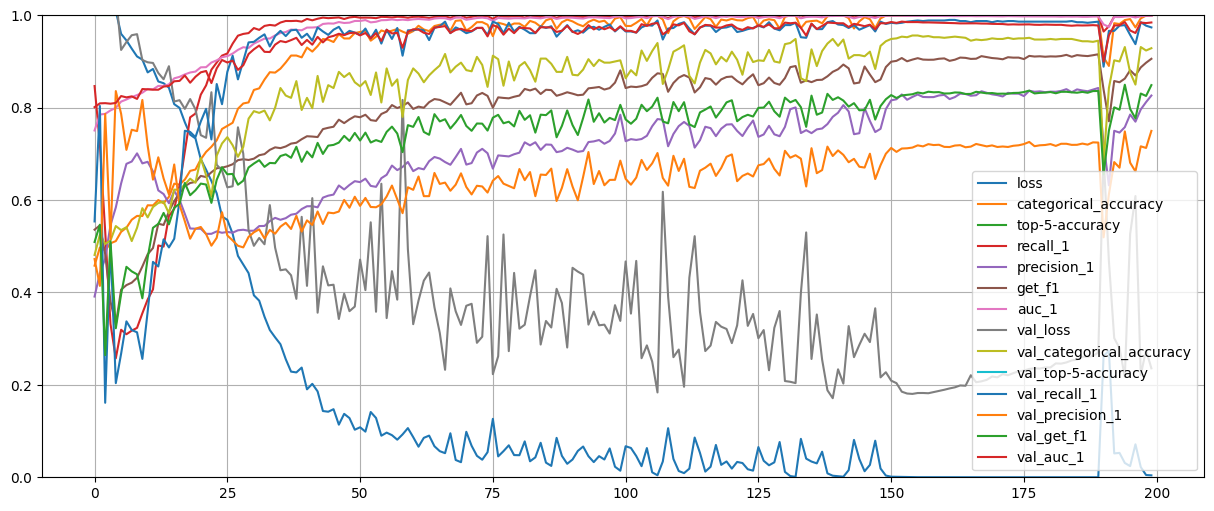

In [25]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("_Bivit_with_Aug.png")
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'top-5-accuracy', 'recall', 'precision', 'get_f1', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_top-5-accuracy', 'val_recall', 'val_precision', 'val_get_f1', 'val_auc'])

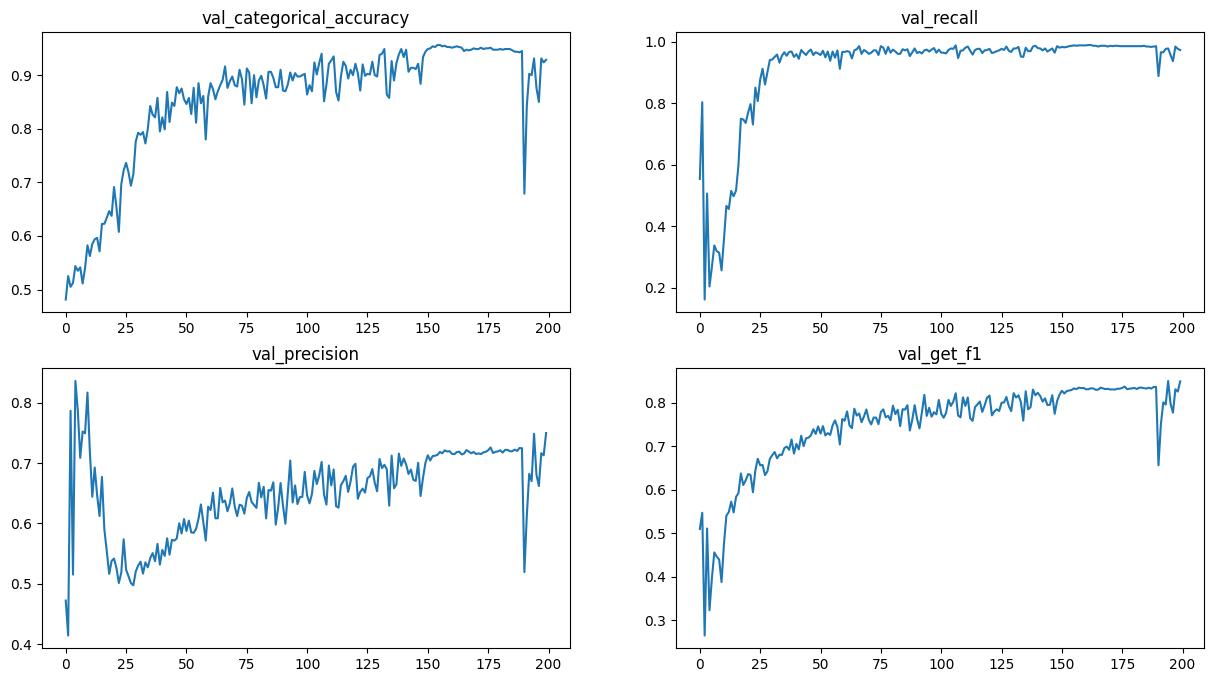

In [24]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,8)
plt.subplot(2,2,1)
plt.plot(history.history['val_categorical_accuracy'])
plt.title('val_categorical_accuracy')
plt.subplot(2,2,2)
plt.plot(history.history['val_recall_1'])
plt.title('val_recall')
plt.subplot(2,2,3)
plt.plot(history.history['val_precision_1'])
plt.title('val_precision')
plt.subplot(2,2,4)
plt.plot(history.history['val_get_f1'])
plt.title('val_get_f1')
plt.savefig('Seperate_BiViT_withAUG.png')
plt.show()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)))

25/25 [==============================] - 2s 32ms/step
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       142
           1       0.80      1.00      0.89         8
           2       0.93      0.96      0.94       385
           3       0.93      0.90      0.91       265

    accuracy                           0.93       800
   macro avg       0.90      0.94      0.92       800
weighted avg       0.93      0.93      0.93       800



In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1))

25/25 [==============================] - 1s 28ms/step


array([[128,   2,   6,   6],
       [  0,   8,   0,   0],
       [  4,   0, 368,  13],
       [  6,   0,  20, 239]])

25/25 [==============================] - 1s 29ms/step


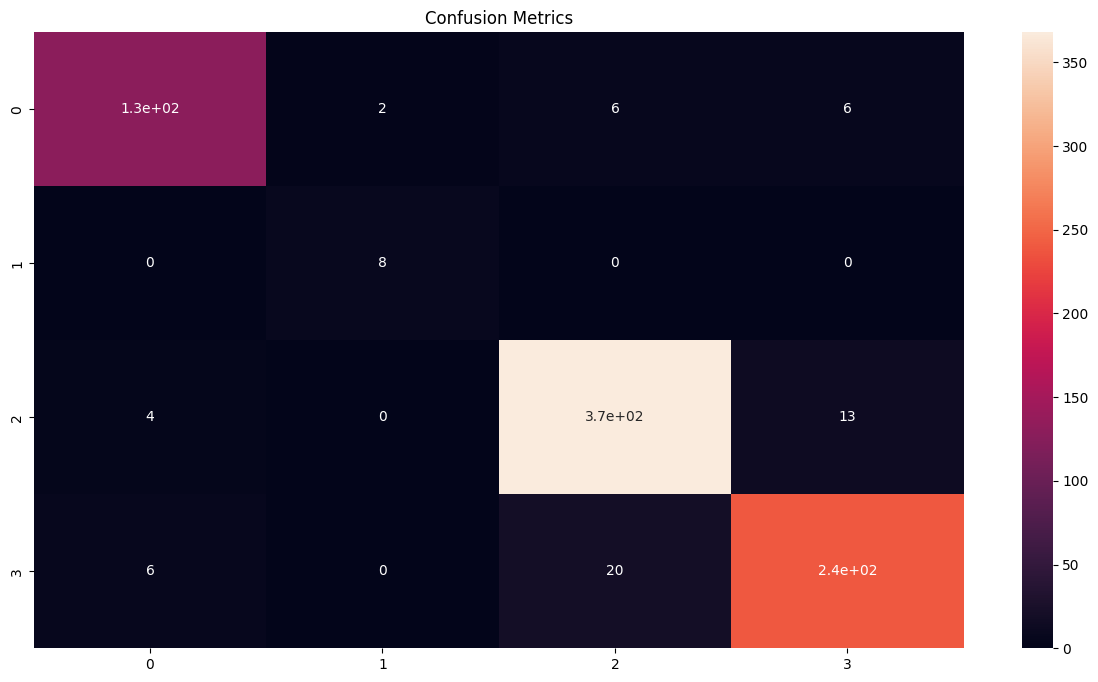

In [23]:
import seaborn as sns
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)),annot=True)
plt.title('Confusion Metrics')
plt.show()

## Transfer Learning

In [ ]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

## DenseNet121

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 28s 60ms/step - loss: 1.7747 - categorical_accuracy: 0.4680 - recall: 0.9854 - precision: 0.3062 - get_f1: 0.4698 - auc: 0.6980 - val_loss: 1.7827 - val_categorical_accuracy: 0.3938 - val_recall: 0.9962 - val_precision: 0.3164 - val_get_f1: 0.4804 - val_auc: 0.6657
Epoch 2/50
175/175 [==============================] - 9s 50ms/step - loss: 1.5732 - categorical_accuracy: 0.4934 - recall: 0.9952 - precision: 0.3097 - get_f1: 0.4740 - auc: 0.6989 - val_loss: 1.5433 - val_categorical_accuracy: 0.5713 - val_recall: 0.9950 - val_precision: 0.3097 - val_get_f1: 0.4725 - val_auc: 0.7605
Epoch 3/50
175/175 [==============================] - 10s 58ms/step - loss: 1.6168 - categorical_accuracy: 0.4991 - recall: 0.9962 - precision: 0.2986 - get_f1: 0.4610 - auc: 0.7054 - val_loss: 1.1680 - val_categorical_accuracy: 0.5725 - val_recall: 1.0000 - val_precision: 0.3075 - val_get_f1: 0.4704 - val_auc: 0.6945
Epoch 4/50
175/175 [=====================

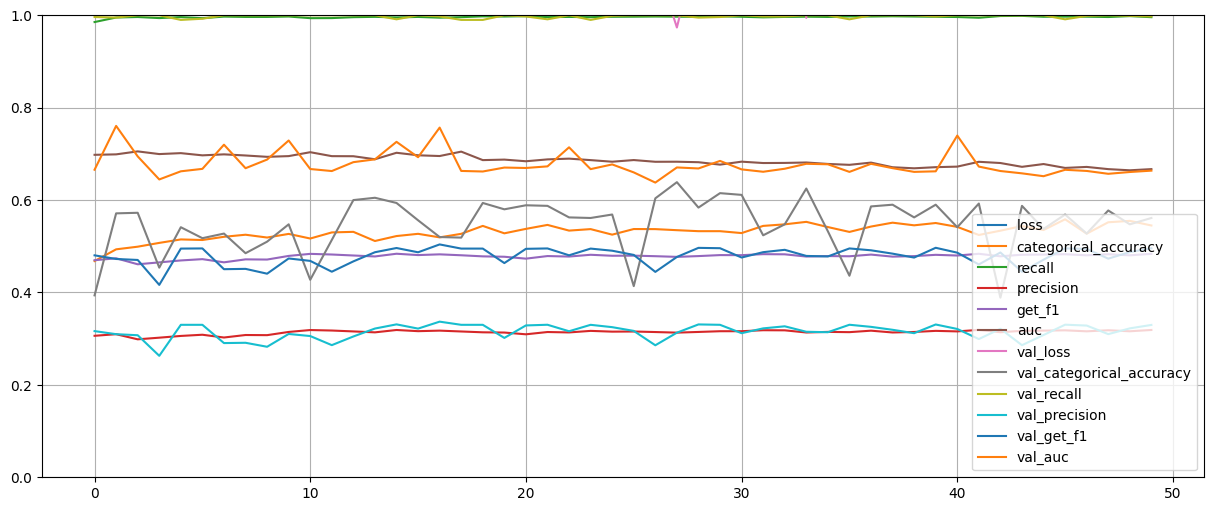

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Densenet121_with_Aug.pdf")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

           0       0.42      0.40      0.41       118
           1       1.00      0.12      0.22         8
           2       0.59      0.91      0.71       404
           3       0.56      0.12      0.20       270

    accuracy                           0.56       800
   macro avg       0.64      0.39      0.39       800
weighted avg       0.56      0.56      0.49       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.0579239790230496
0.0034663571275098883
0.016009978089474613
0.01851202368534067
0.02627900237820437
0.5477499985694885
0.9976249969005585
0.3154038792848587
0.47911802291870115
0.677449951171875


## Resnet 50

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 18s 67ms/step - loss: 1.0794 - categorical_accuracy: 0.4920 - recall_1: 0.9289 - precision_1: 0.3716 - get_f1: 0.5341 - auc_1: 0.7770 - val_loss: 1.2942 - val_categorical_accuracy: 0.3375 - val_recall_1: 0.9375 - val_precision_1: 0.3326 - val_get_f1: 0.4911 - val_auc_1: 0.6774
Epoch 2/50
175/175 [==============================] - 8s 49ms/step - loss: 1.0449 - categorical_accuracy: 0.4979 - recall_1: 0.9377 - precision_1: 0.3718 - get_f1: 0.5349 - auc_1: 0.7885 - val_loss: 1.1493 - val_categorical_accuracy: 0.4250 - val_recall_1: 0.9787 - val_precision_1: 0.3297 - val_get_f1: 0.4932 - val_auc_1: 0.7233
Epoch 3/50
175/175 [==============================] - 9s 54ms/step - loss: 1.0377 - categorical_accuracy: 0.4898 - recall_1: 0.9432 - precision_1: 0.3712 - get_f1: 0.5347 - auc_1: 0.7909 - val_loss: 1.0503 - val_categorical_accuracy: 0.4762 - val_recall_1: 0.9787 - val_precision_1: 0.3333 - val_get_f1: 0.4973 - val_auc_1: 0.7792
Epoch 

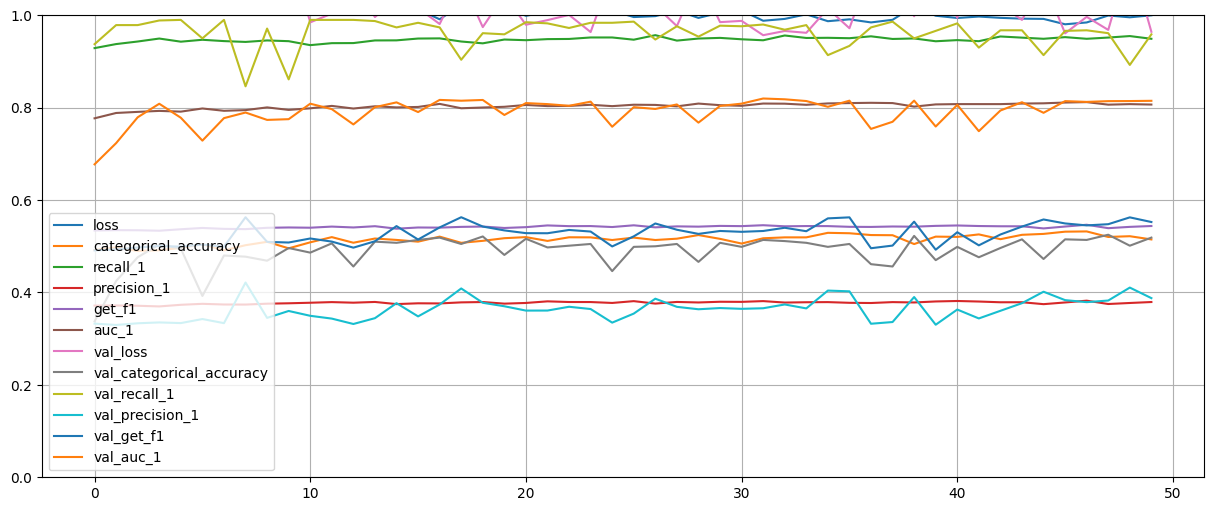

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 3s 44ms/step
              precision    recall  f1-score   support

           0       0.50      0.04      0.08       118
           1       0.00      0.00      0.00         8
           2       0.62      0.66      0.64       404
           3       0.40      0.53      0.45       270

    accuracy                           0.52       800
   macro avg       0.38      0.31      0.29       800
weighted avg       0.52      0.52      0.49       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.033742998275115524
0.03202547113733408
0.02397101459131884
0.022116961072577743
0.028757912266179946
0.4896000027656555
0.9617749977111817
0.36351567566394805
0.526959558725357
0.7916421818733216


## VGG16

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 33s 69ms/step - loss: 1.0749 - categorical_accuracy: 0.4932 - recall: 0.9214 - precision: 0.3719 - get_f1: 0.5308 - auc: 0.7727 - val_loss: 0.9367 - val_categorical_accuracy: 0.5750 - val_recall: 0.9650 - val_precision: 0.3935 - val_get_f1: 0.5592 - val_auc: 0.8324
Epoch 2/50
175/175 [==============================] - 9s 51ms/step - loss: 0.9913 - categorical_accuracy: 0.5366 - recall: 0.9212 - precision: 0.4005 - get_f1: 0.5588 - auc: 0.8067 - val_loss: 0.9276 - val_categorical_accuracy: 0.5888 - val_recall: 0.9762 - val_precision: 0.3680 - val_get_f1: 0.5349 - val_auc: 0.8395
Epoch 3/50
175/175 [==============================] - 9s 54ms/step - loss: 0.9798 - categorical_accuracy: 0.5405 - recall: 0.9204 - precision: 0.4040 - get_f1: 0.5623 - auc: 0.8133 - val_loss: 0.8931 - val_categorical_accuracy: 0.5775 - val_recall: 0.9775 - val_precision: 0.3751 - val_get_f1: 0.5425 - val_auc: 0.8509
Epoch 4/50
175/175 [======================

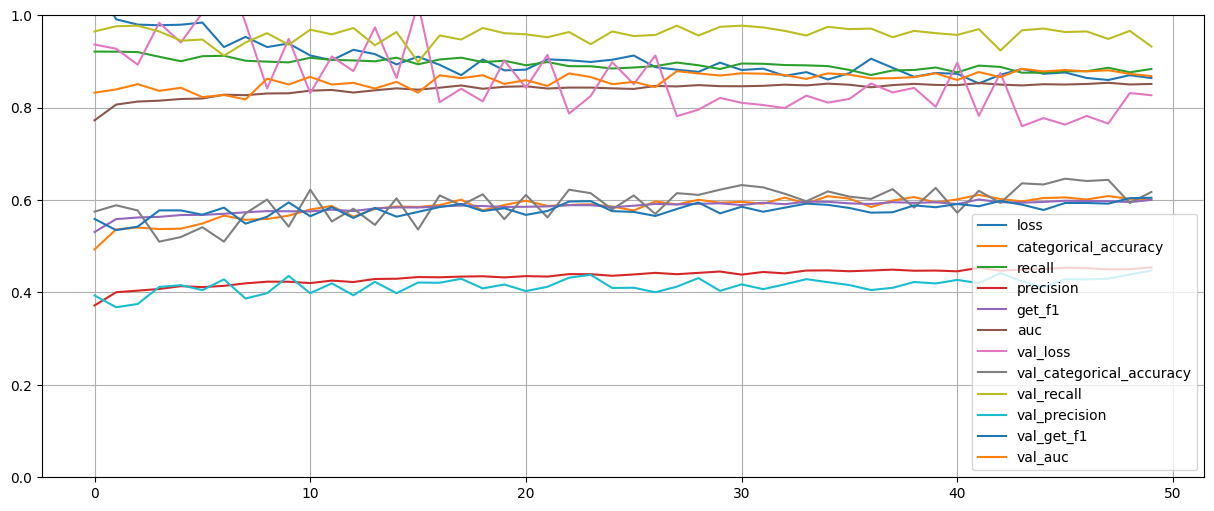

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("VGG16_with_Aug.pdf")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 2s 49ms/step
              precision    recall  f1-score   support

           0       0.69      0.17      0.27       107
           1       1.00      0.58      0.74        12
           2       0.78      0.61      0.68       390
           3       0.50      0.79      0.61       291

    accuracy                           0.62       800
   macro avg       0.74      0.54      0.58       800
weighted avg       0.67      0.62      0.60       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.03462551066425171
0.016588326399807864
0.016017861557921353
0.014635173112180046
0.016294078613877164
0.5940750002861023
0.9579500019550323
0.41540408849716187
0.5796569240093231
0.860074942111969


## IncepTionResnetV2

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

219055592/219055592 [==============================] - 6s 0us/step


Epoch 1/50
175/175 [==============================] - 39s 140ms/step - loss: 1.5991 - categorical_accuracy: 0.4736 - recall_1: 0.8091 - precision_1: 0.3816 - get_f1: 0.5192 - auc_1: 0.7476 - val_loss: 1.6500 - val_categorical_accuracy: 0.5650 - val_recall_1: 0.9025 - val_precision_1: 0.4164 - val_get_f1: 0.5698 - val_auc_1: 0.7976
Epoch 2/50
175/175 [==============================] - 17s 96ms/step - loss: 1.4795 - categorical_accuracy: 0.5018 - recall_1: 0.8786 - precision_1: 0.3791 - get_f1: 0.5305 - auc_1: 0.7643 - val_loss: 1.2711 - val_categorical_accuracy: 0.5150 - val_recall_1: 0.9638 - val_precision_1: 0.3604 - val_get_f1: 0.5250 - val_auc_1: 0.7629
Epoch 3/50
175/175 [==============================] - 15s 87ms/step - loss: 1.3846 - categorical_accuracy: 0.4959 - recall_1: 0.8836 - precision_1: 0.3813 - get_f1: 0.5341 - auc_1: 0.7672 - val_loss: 1.4298 - val_categorical_accuracy: 0.5188 - val_recall_1: 0.9588 - val_precision_1: 0.3856 - val_get_f1: 0.5505 - val_auc_1: 0.7868
Epo

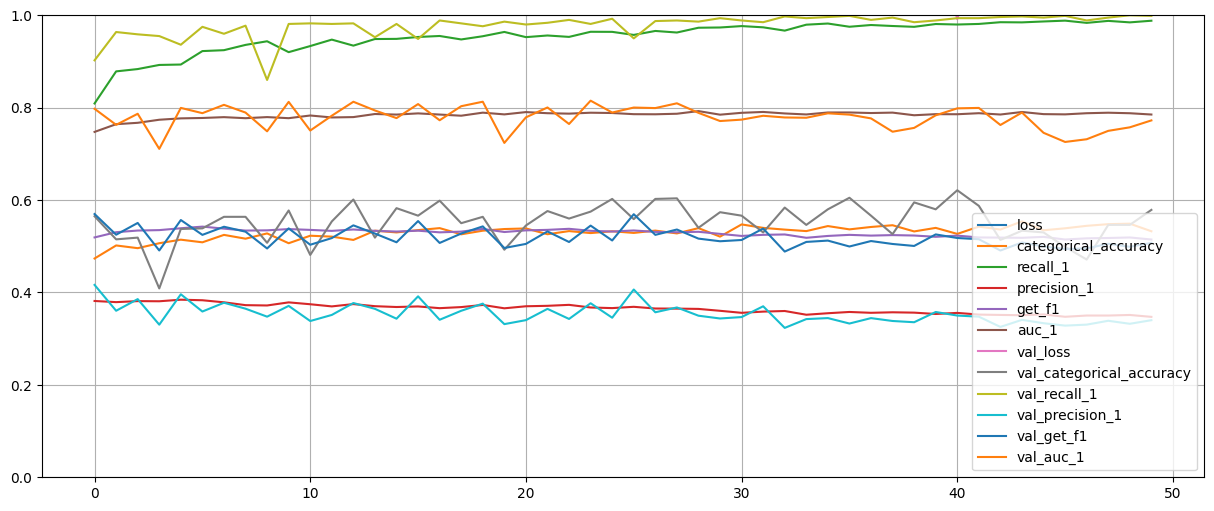

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("InceptionResnetV2_with_Aug.pdf")
plt.show()

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 5s 57ms/step
              precision    recall  f1-score   support

           0       0.41      0.21      0.27       107
           1       1.00      0.33      0.50        12
           2       0.84      0.49      0.62       390
           3       0.48      0.85      0.61       291

    accuracy                           0.58       800
   macro avg       0.68      0.47      0.50       800
weighted avg       0.65      0.58      0.57       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.03972789626596566
0.025164258622953597
0.02107946880115102
0.020491277378222872
0.024878280777901638
0.5529750019311905
0.978849993944168
0.35361825823783877
0.5191193413734436
0.7788361930847167


## InceptionV3

In [ ]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 33s 48ms/step - loss: 2.1285 - categorical_accuracy: 0.4573 - recall: 0.9846 - precision: 0.2904 - get_f1: 0.4542 - auc: 0.6548 - val_loss: 2.0773 - val_categorical_accuracy: 0.5063 - val_recall: 1.0000 - val_precision: 0.2556 - val_get_f1: 0.4072 - val_auc: 0.6256
Epoch 2/50
175/175 [==============================] - 7s 38ms/step - loss: 1.6773 - categorical_accuracy: 0.4632 - recall: 0.9964 - precision: 0.2930 - get_f1: 0.4562 - auc: 0.6480 - val_loss: 1.7992 - val_categorical_accuracy: 0.5387 - val_recall: 0.9850 - val_precision: 0.3283 - val_get_f1: 0.4925 - val_auc: 0.6663
Epoch 3/50
175/175 [==============================] - 6s 33ms/step - loss: 1.8787 - categorical_accuracy: 0.4732 - recall: 0.9962 - precision: 0.2921 - get_f1: 0.4543 - auc: 0.6491 - val_loss: 1.9995 - val_categorical_accuracy: 0.5100 - val_recall: 1.0000 - val_precision: 0.2588 - val_get_f1: 0.4113 - val_auc: 0.6649
Epoch 4/50
175/175 [======================

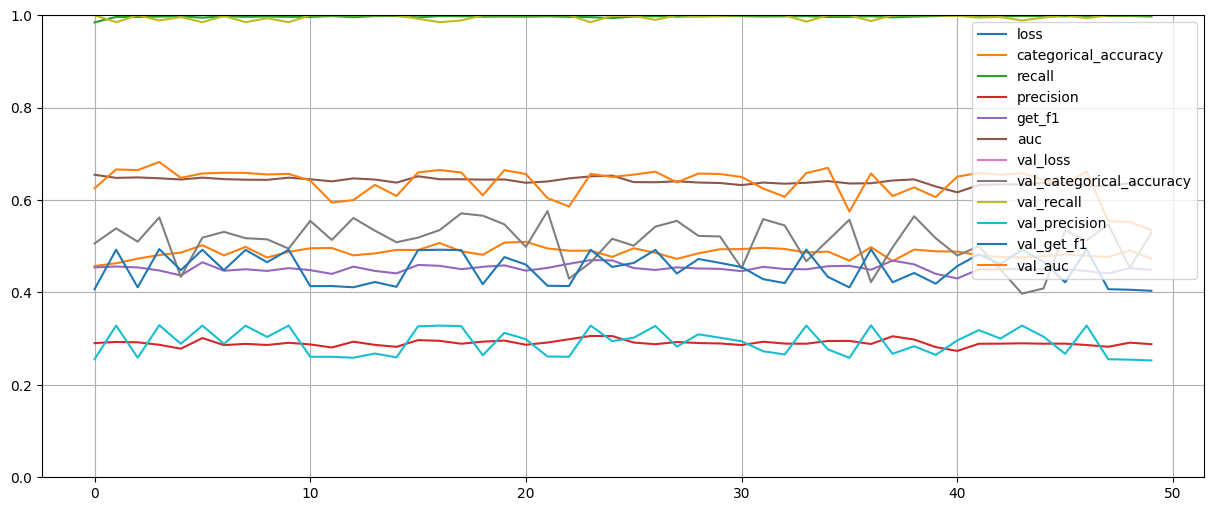

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("InceptionV3_with_Aug.pdf")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.43      0.22      0.29       109
           1       0.06      0.58      0.11        12
           2       0.71      0.76      0.74       399
           3       0.43      0.31      0.36       280

    accuracy                           0.53       800
   macro avg       0.41      0.47      0.38       800
weighted avg       0.57      0.53      0.54       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.04374254298926248
0.0055691641952303585
0.02791256955873229
0.03280777687904246
0.03314782175546025
0.5115500032901764
0.9958749961853027
0.2924222046136856
0.45139842927455903
0.636566356420517


## EfficientNetB0

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

16705208/16705208 [==============================] - 1s 0us/step


Epoch 1/50
175/175 [==============================] - 17s 47ms/step - loss: 1.3748 - categorical_accuracy: 0.4261 - recall_1: 0.9896 - precision_1: 0.2920 - get_f1: 0.4566 - auc_1: 0.6828 - val_loss: 1.4182 - val_categorical_accuracy: 0.4988 - val_recall_1: 1.0000 - val_precision_1: 0.2500 - val_get_f1: 0.4000 - val_auc_1: 0.7527
Epoch 2/50
175/175 [==============================] - 6s 34ms/step - loss: 1.3587 - categorical_accuracy: 0.4343 - recall_1: 0.9959 - precision_1: 0.2837 - get_f1: 0.4466 - auc_1: 0.6771 - val_loss: 1.0858 - val_categorical_accuracy: 0.4988 - val_recall_1: 1.0000 - val_precision_1: 0.2500 - val_get_f1: 0.4000 - val_auc_1: 0.6567
Epoch 3/50
175/175 [==============================] - 5s 30ms/step - loss: 1.2289 - categorical_accuracy: 0.4339 - recall_1: 0.9986 - precision_1: 0.2565 - get_f1: 0.4097 - auc_1: 0.6848 - val_loss: 1.2305 - val_categorical_accuracy: 0.3500 - val_recall_1: 1.0000 - val_precision_1: 0.2500 - val_get_f1: 0.4000 - val_auc_1: 0.6571
Epoch 

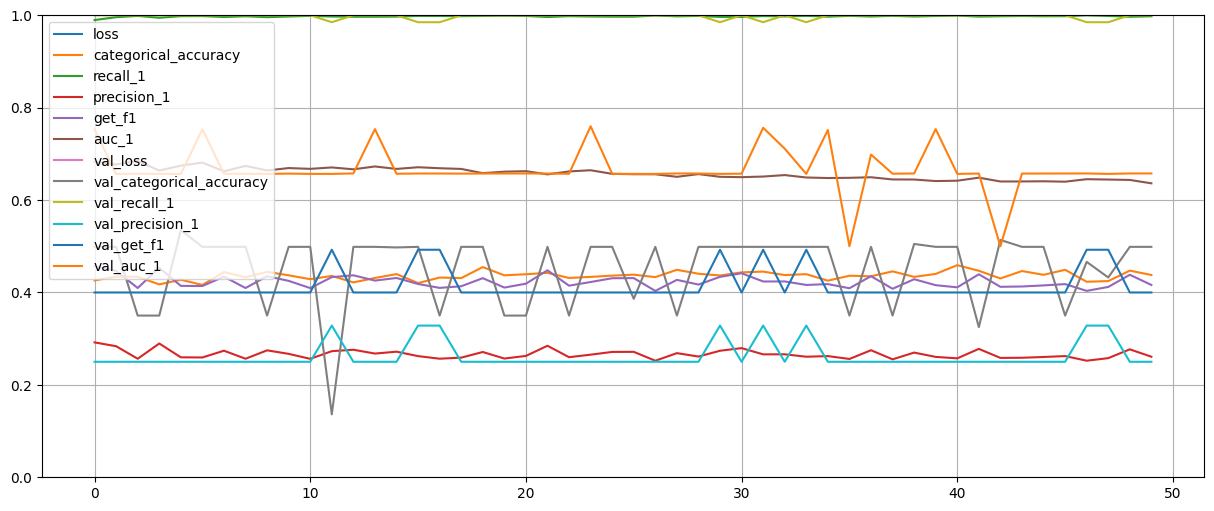

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("EfficientNetB0_with_Aug.pdf")
plt.show()

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.00      0.00      0.00        12
           2       0.50      1.00      0.67       399
           3       0.00      0.00      0.00       280

    accuracy                           0.50       800
   macro avg       0.12      0.25      0.17       800
weighted avg       0.25      0.50      0.33       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.07953912867657349
0.005499085589605316
0.028717479745074447
0.03391104965398983
0.048182688263616255
0.4521999999880791
0.9976000022888184
0.26253333568573
0.41479997158050536
0.6663940966129303


## EfficientNetB1

In [ ]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 41s 81ms/step - loss: 1.5276 - categorical_accuracy: 0.4268 - recall: 0.9916 - precision: 0.2701 - get_f1: 0.4295 - auc: 0.6639 - val_loss: 1.4571 - val_categorical_accuracy: 0.5063 - val_recall: 0.9875 - val_precision: 0.3292 - val_get_f1: 0.4937 - val_auc: 0.6583
Epoch 2/50
175/175 [==============================] - 7s 39ms/step - loss: 1.2771 - categorical_accuracy: 0.4339 - recall: 0.9964 - precision: 0.2756 - get_f1: 0.4366 - auc: 0.6565 - val_loss: 1.1812 - val_categorical_accuracy: 0.5063 - val_recall: 1.0000 - val_precision: 0.2500 - val_get_f1: 0.4000 - val_auc: 0.6591
Epoch 3/50
175/175 [==============================] - 7s 42ms/step - loss: 1.2256 - categorical_accuracy: 0.4480 - recall: 0.9995 - precision: 0.2554 - get_f1: 0.4083 - auc: 0.6470 - val_loss: 1.1388 - val_categorical_accuracy: 0.3375 - val_recall: 1.0000 - val_precision: 0.2500 - val_get_f1: 0.4000 - val_auc: 0.6589
Epoch 4/50
175/175 [======================

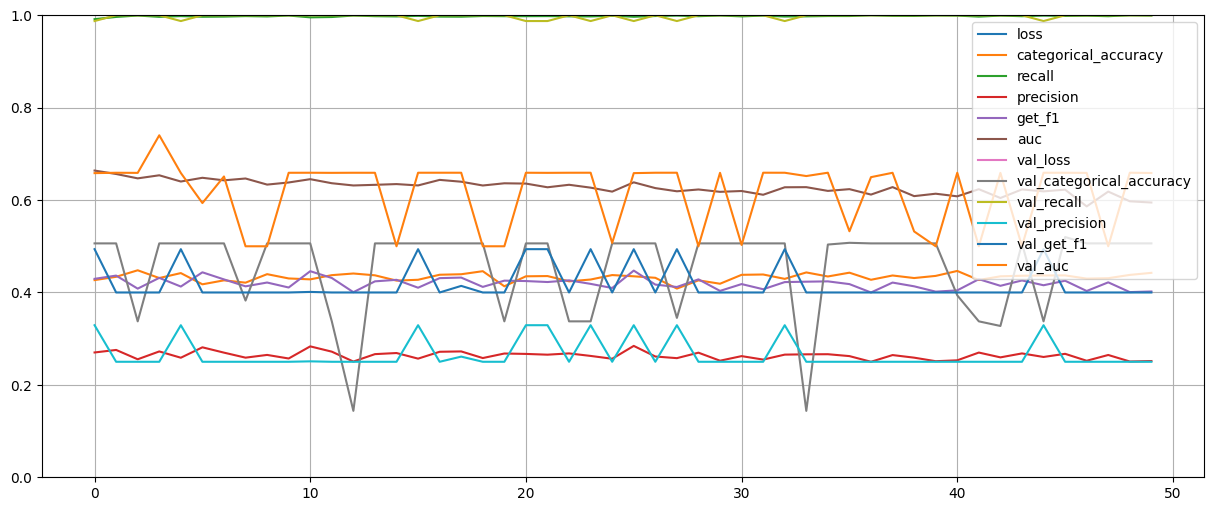

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("EfficientB1_with_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 3s 33ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00        10
           2       0.51      1.00      0.67       405
           3       0.00      0.00      0.00       270

    accuracy                           0.51       800
   macro avg       0.13      0.25      0.17       800
weighted avg       0.26      0.51      0.34       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.09233101610138544
0.004999995231628418
0.031584171638664164
0.03739851445746729
0.07073460060099528
0.4568500167131424
0.9975000023841858
0.26607579410076143
0.41905934929847716
0.6158229506015778


## VGG19

In [ ]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 25s 75ms/step - loss: 1.0541 - categorical_accuracy: 0.4902 - recall: 0.6782 - precision: 0.4488 - get_f1: 0.5396 - auc: 0.7882 - val_loss: 0.9581 - val_categorical_accuracy: 0.5163 - val_recall: 0.7237 - val_precision: 0.4829 - val_get_f1: 0.5793 - val_auc: 0.8228
Epoch 2/50
175/175 [==============================] - 12s 69ms/step - loss: 0.9845 - categorical_accuracy: 0.5302 - recall: 0.6966 - precision: 0.4765 - get_f1: 0.5655 - auc: 0.8133 - val_loss: 1.0530 - val_categorical_accuracy: 0.5288 - val_recall: 0.7713 - val_precision: 0.4746 - val_get_f1: 0.5879 - val_auc: 0.8243
Epoch 3/50
175/175 [==============================] - 12s 70ms/step - loss: 0.9711 - categorical_accuracy: 0.5427 - recall: 0.6941 - precision: 0.4834 - get_f1: 0.5692 - auc: 0.8186 - val_loss: 0.9605 - val_categorical_accuracy: 0.5650 - val_recall: 0.6112 - val_precision: 0.5164 - val_get_f1: 0.5595 - val_auc: 0.8221
Epoch 4/50
175/175 [====================

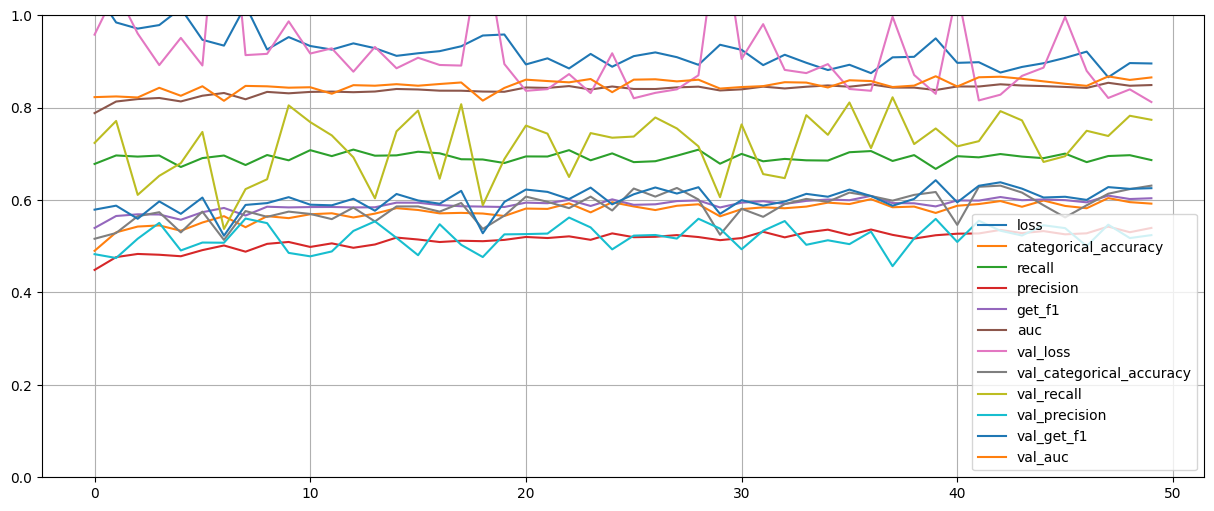

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("VGG19_with_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 2s 51ms/step
              precision    recall  f1-score   support

           0       0.53      0.36      0.43       113
           1       0.75      0.27      0.40        11
           2       0.73      0.74      0.73       402
           3       0.53      0.60      0.56       274

    accuracy                           0.63       800
   macro avg       0.63      0.49      0.53       800
weighted avg       0.63      0.63      0.63       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.03056224339855743
0.06501408228363555
0.026354214987669808
0.02380383764386415
0.013338287472660285
0.5840750014781952
0.7190249979496002
0.5201679968833923
0.6016319239139557
0.8486141812801361


## Resnet101

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

171446536/171446536 [==============================] - 6s 0us/step


Epoch 1/50
175/175 [==============================] - 29s 101ms/step - loss: 1.0527 - categorical_accuracy: 0.4837 - recall_1: 0.9666 - precision_1: 0.3447 - get_f1: 0.5092 - auc_1: 0.7789 - val_loss: 1.0239 - val_categorical_accuracy: 0.4988 - val_recall_1: 0.9862 - val_precision_1: 0.3317 - val_get_f1: 0.4964 - val_auc_1: 0.8008
Epoch 2/50
175/175 [==============================] - 15s 89ms/step - loss: 1.0525 - categorical_accuracy: 0.4804 - recall_1: 0.9737 - precision_1: 0.3457 - get_f1: 0.5114 - auc_1: 0.7836 - val_loss: 1.0474 - val_categorical_accuracy: 0.5050 - val_recall_1: 0.9613 - val_precision_1: 0.3634 - val_get_f1: 0.5276 - val_auc_1: 0.8036
Epoch 3/50
175/175 [==============================] - 14s 83ms/step - loss: 1.0298 - categorical_accuracy: 0.4911 - recall_1: 0.9779 - precision_1: 0.3469 - get_f1: 0.5134 - auc_1: 0.7917 - val_loss: 1.0404 - val_categorical_accuracy: 0.5125 - val_recall_1: 0.9862 - val_precision_1: 0.3297 - val_get_f1: 0.4942 - val_auc_1: 0.7932
Epo

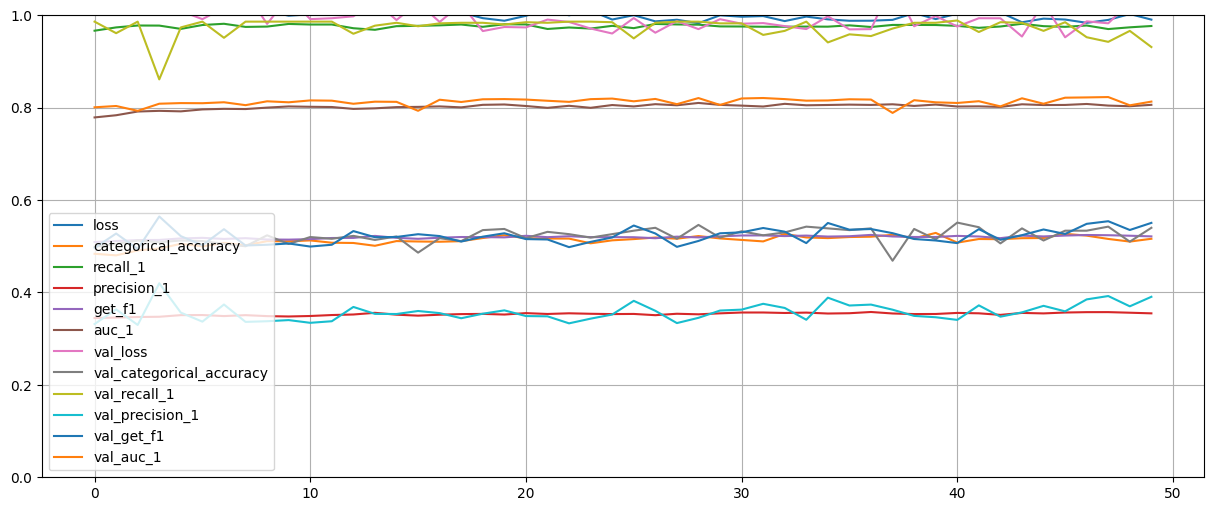

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Resnet101_with_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 3s 58ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.00      0.00      0.00        11
           2       0.70      0.60      0.65       402
           3       0.42      0.70      0.52       274

    accuracy                           0.54       800
   macro avg       0.28      0.32      0.29       800
weighted avg       0.50      0.54      0.50       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.01612507822136764
0.021571465343661406
0.01853657919168768
0.016570458627786507
0.0074930891455202075
0.5222250032424927
0.9726249945163726
0.35762480318546297
0.5225617516040802
0.8125281524658203


## MobileNet

In [7]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

17225924/17225924 [==============================] - 0s 0us/step


Epoch 1/50
175/175 [==============================] - 17s 29ms/step - loss: 1.9365 - categorical_accuracy: 0.4982 - recall: 0.9498 - precision: 0.3549 - get_f1: 0.5174 - auc: 0.7689 - val_loss: 1.1453 - val_categorical_accuracy: 0.5825 - val_recall: 0.9862 - val_precision: 0.3521 - val_get_f1: 0.5190 - val_auc: 0.8371
Epoch 2/50
175/175 [==============================] - 4s 23ms/step - loss: 1.6710 - categorical_accuracy: 0.5248 - recall: 0.9646 - precision: 0.3566 - get_f1: 0.5214 - auc: 0.7927 - val_loss: 1.5137 - val_categorical_accuracy: 0.5375 - val_recall: 0.9812 - val_precision: 0.3319 - val_get_f1: 0.4963 - val_auc: 0.7990
Epoch 3/50
175/175 [==============================] - 4s 23ms/step - loss: 1.7802 - categorical_accuracy: 0.5361 - recall: 0.9607 - precision: 0.3693 - get_f1: 0.5343 - auc: 0.7963 - val_loss: 2.1291 - val_categorical_accuracy: 0.4375 - val_recall: 0.9525 - val_precision: 0.3416 - val_get_f1: 0.5029 - val_auc: 0.7337
Epoch 4/50
175/175 [======================

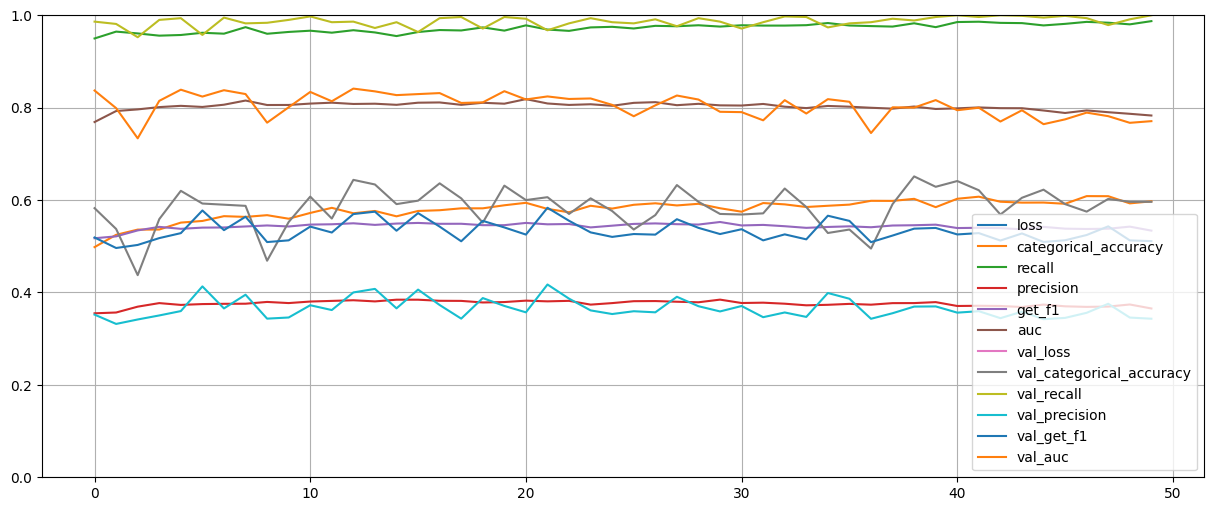

In [8]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Mobilenet_with_Aug.png")
plt.show()

In [9]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.35      0.72      0.47       108
           1       1.00      0.70      0.82        10
           2       0.77      0.60      0.67       399
           3       0.60      0.54      0.57       283

    accuracy                           0.60       800
   macro avg       0.68      0.64      0.63       800
weighted avg       0.65      0.60      0.61       800



In [10]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.04241155711367705
0.011038112830531237
0.020870324545013915
0.021092485740079818
0.025402816833158058
0.5849000012874603
0.9866499936580658
0.3653948312997818
0.5330958217382431
0.8045828223228455


## Xception

In [11]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

83683744/83683744 [==============================] - 0s 0us/step


Epoch 1/50
175/175 [==============================] - 19s 65ms/step - loss: 1.7504 - categorical_accuracy: 0.4693 - recall_1: 0.9855 - precision_1: 0.3046 - get_f1: 0.4674 - auc_1: 0.7088 - val_loss: 1.6780 - val_categorical_accuracy: 0.5337 - val_recall_1: 0.9900 - val_precision_1: 0.3297 - val_get_f1: 0.4947 - val_auc_1: 0.7550
Epoch 2/50
175/175 [==============================] - 9s 53ms/step - loss: 1.8510 - categorical_accuracy: 0.4823 - recall_1: 0.9925 - precision_1: 0.3050 - get_f1: 0.4679 - auc_1: 0.7116 - val_loss: 1.2991 - val_categorical_accuracy: 0.5500 - val_recall_1: 0.9912 - val_precision_1: 0.3224 - val_get_f1: 0.4865 - val_auc_1: 0.7073
Epoch 3/50
175/175 [==============================] - 9s 54ms/step - loss: 1.7262 - categorical_accuracy: 0.4854 - recall_1: 0.9954 - precision_1: 0.3021 - get_f1: 0.4649 - auc_1: 0.7060 - val_loss: 1.6905 - val_categorical_accuracy: 0.5213 - val_recall_1: 0.9875 - val_precision_1: 0.3292 - val_get_f1: 0.4937 - val_auc_1: 0.6717
Epoch 

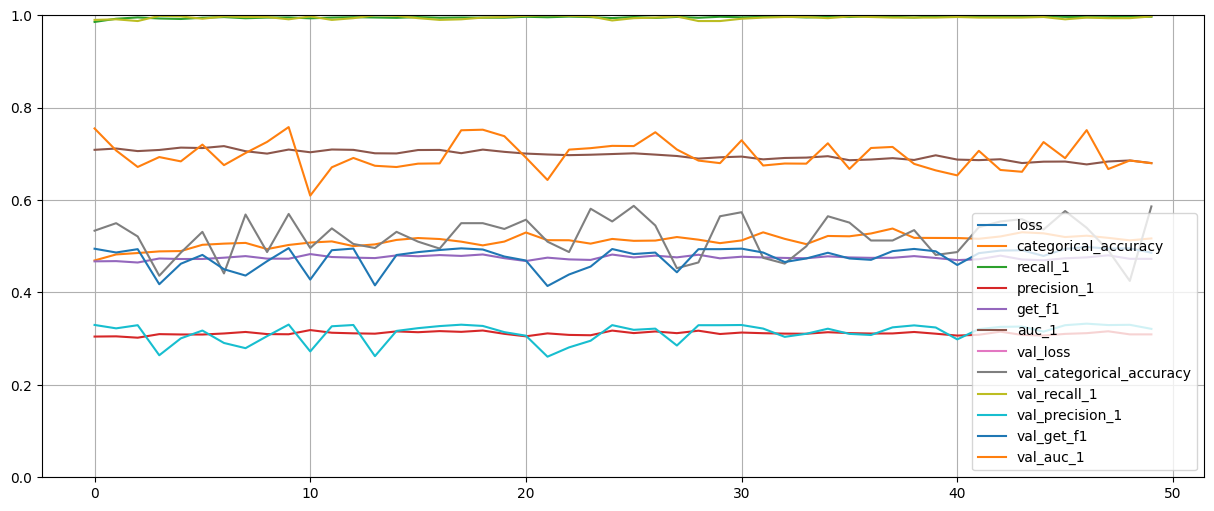

In [12]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Xception_with_Aug.png")
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 2s 45ms/step
              precision    recall  f1-score   support

           0       0.68      0.12      0.20       108
           1       0.00      0.00      0.00        10
           2       0.73      0.63      0.68       399
           3       0.47      0.72      0.57       283

    accuracy                           0.59       800
   macro avg       0.47      0.37      0.36       800
weighted avg       0.62      0.59      0.57       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.04095367042639874
0.0032137360640612034
0.01968633035224292
0.022988755442732517
0.03162254722274999
0.5221250015497207
0.9946249914169312
0.3133960062265396
0.47631665408611296
0.6966533720493316


## ResNet152

In [15]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

234698864/234698864 [==============================] - 2s 0us/step


Epoch 1/50
175/175 [==============================] - 31s 116ms/step - loss: 1.0770 - categorical_accuracy: 0.4736 - recall_2: 0.9780 - precision_2: 0.3349 - get_f1: 0.4987 - auc_2: 0.7661 - val_loss: 1.0529 - val_categorical_accuracy: 0.4988 - val_recall_2: 0.9875 - val_precision_2: 0.3297 - val_get_f1: 0.4944 - val_auc_2: 0.8022
Epoch 2/50
175/175 [==============================] - 17s 95ms/step - loss: 1.0244 - categorical_accuracy: 0.4925 - recall_2: 0.9884 - precision_2: 0.3348 - get_f1: 0.5004 - auc_2: 0.7921 - val_loss: 1.0027 - val_categorical_accuracy: 0.4988 - val_recall_2: 0.9875 - val_precision_2: 0.3296 - val_get_f1: 0.4942 - val_auc_2: 0.8037
Epoch 3/50
175/175 [==============================] - 17s 97ms/step - loss: 1.0268 - categorical_accuracy: 0.4934 - recall_2: 0.9846 - precision_2: 0.3372 - get_f1: 0.5030 - auc_2: 0.7914 - val_loss: 1.0141 - val_categorical_accuracy: 0.5138 - val_recall_2: 0.9862 - val_precision_2: 0.3380 - val_get_f1: 0.5036 - val_auc_2: 0.8102
Epo

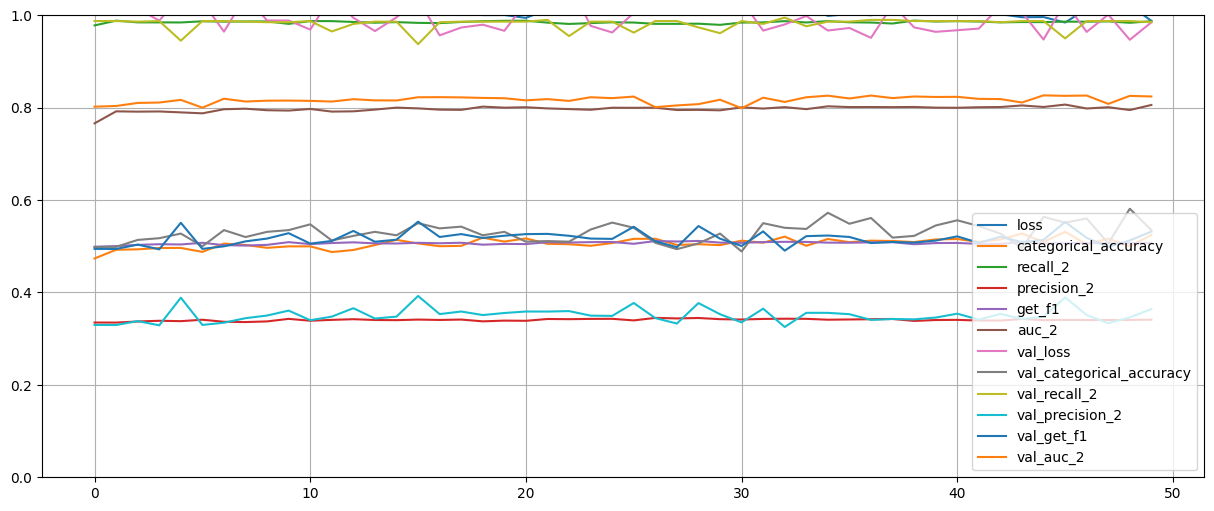

In [16]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Resnet152_with_Aug.png")
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 5s 78ms/step
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       108
           1       0.00      0.00      0.00        10
           2       0.56      0.86      0.68       399
           3       0.46      0.29      0.35       283

    accuracy                           0.54       800
   macro avg       0.50      0.29      0.26       800
weighted avg       0.57      0.54      0.47       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_2']))
print(np.std(history.history['val_precision_2']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_2']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_2']))
print(np.mean(history.history['val_precision_2']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_2']))

0.02120213669806836
0.01222214124932145
0.015262068564956849
0.015072539095239836
0.007406773981014036
0.530025001168251
0.9817750000953674
0.35072224497795107
0.5166645658016205
0.8169262993335724
